In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [23]:
class G_n_plusplus:
    def __init__(self, n_factor = 2) -> None:
        """
        Augs
            discount_factor_vec: 割引率のベクトル。スワップのCFに合う形を想定
        """
        # ファクターの数を設定する。
        self.n_factor = n_factor        

        # 初期値を設定する
        self.variance_vec = np.array([1] * n_factor)
        self.drift_vec = np.array([1] * n_factor)
        self.a_vec = np.array([1] * n_factor)
        self.correlation_mat = np.eye(self.n_factor)


    def _calc_swaption_price(self, maturity, strike, nominal_value, first_swap_time, time_fraction, n_swap, discount_factor_vec) -> float:
        """
        Augs
            marurity: スワップション満期（年）
            strike: スワップションの行使価格
            nominal_value: よくわからんけど、論文だと"N"
            first_swap_time: スワップ行使の開始時点（年）
            time_fraction: スワップ行使の時間幅(年)
            n_swap: スワップ回数
            discount_factor_vec: 割引率のベクトル。スワップのCFに合う形を想定(長さは"n_swap"と一致。)
        """ 
        # 入力を整理
        self.maturity = maturity
        self.strike = strike
        self.nominal_value = nominal_value
        self.first_swap_time = first_swap_time
        self.time_fraction = time_fraction
        self.n_swap = n_swap
        self.discount_factor_vec = discount_factor_vec

        # 最後のスワップの時刻をfinal_swap_timeとする
        self.final_swap_time = self.first_swap_time + self.time_fraction * self.n_swap

        # time fractionとDiscount Factorの積和を計算する。（ここでは、time fractionが定数と仮定しているため、Discount Factorの和にtime fractionをあとから掛けている）
        self.P = sum(self.discount_factor_vec) * self.time_fraction
        
        # Aのリストを作成する
        self._calc_A()

        # VOLを計算する
        self._calc_VOL()
        
        # 理論解を計算
        self.theoretical_swaption_price = self.nominal_value * self.VOL * self.P / math.sqrt(2 * np.pi)

    def _calc_A(self) -> list:
        """
        A_i (i = 1, 2, ..., factor数)を作成する。
        calc_swaption_priceのサブ的な関数
        """
        self.A = []
        for i in range(self.n_factor):
            # A の二つ目の項と最後の項を分けて計算
            # self.discount_factor_vec[0]は"P(0, T)"を表す
            A = math.exp(- self.drift_vec[i] * self.maturity) * self.discount_factor_vec[0] / self.P - math.exp(- self.drift_vec[i] * self.final_swap_time) * self.discount_factor_vec[-1] / self.P

            final_term_of_A = 0
            for j in range(self.n_swap):
                # スワップの実行時刻
                t_j = self.first_swap_time + self.time_fraction * j

                final_term_of_A += math.exp(- self.drift_vec[i] * t_j) * self.time_fraction * self.discount_factor_vec[j]
            
            final_term_of_A *= - self.strike
            
            # 最後の項を加算
            A += final_term_of_A
            
            # リストに格納
            self.A.append(A)
        
    def _calc_VOL(self) -> float:
        """
        VOLを計算する。calc_swaption_priceのサブ的な関数
        """
        VOL = 0
        for i in range(self.n_factor):
            for j in range(self.n_factor):
                VOL += self.variance_vec[i] * self.variance_vec[j] * self.correlation_mat[i, j] * self.A[i] * self.A[j] * \
                    (math.exp((self.drift_vec[i] + self.drift_vec[j]) * self.maturity) - 1) / (self.drift_vec[i] + self.drift_vec[j])
                
        self.VOL = math.sqrt(VOL)

# set a input

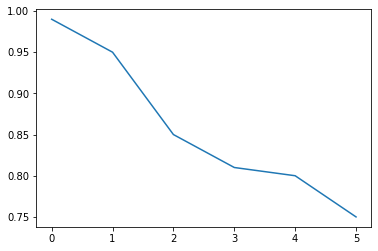

In [24]:
maturity = 10
strike = 0.05
nominal_value = 1
first_swap_time = 11
time_fraction = 0.5
n_swap = 6
discount_factor_vec = [0.99, 0.95, 0.85, 0.81, 0.8, 0.75]

plt.plot(discount_factor_vec)

In [28]:
instance_G_2 = G_n_plusplus()

instance_G_2._calc_swaption_price(maturity=maturity, strike=strike, nominal_value=nominal_value, first_swap_time=first_swap_time, time_fraction=time_fraction, n_swap=n_swap, discount_factor_vec=discount_factor_vec)
instance_G_2.theoretical_swaption_price

0.3684090138614806

In [30]:
instance_G_2.VOL

0.35862697117441217